In [2]:
import numpy as np
import pandas as pd
import healpy as hp
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Standard library
import os
import sys
import warnings

# adjust path and suppress warnings
sys.path.insert(0, os.path.abspath('..'))
warnings.filterwarnings('ignore')

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import healpy as hp

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table

from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree

# Local
import util
import utils


In [3]:
size_ratio = 1
sub_width, sub_height = size_ratio*10/3, size_ratio*2.8
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 10


rc_default = {}
rc_default['font.family'] = 'serif'
rc_default['font.size'] = SMALL_SIZE
rc_default['axes.labelsize'] = MEDIUM_SIZE
rc_default['axes.labelweight'] = 'normal'
rc_default['axes.linewidth'] = 1.0
rc_default['axes.titlesize'] = MEDIUM_SIZE
rc_default['xtick.labelsize'] = SMALL_SIZE
rc_default['ytick.labelsize'] = SMALL_SIZE
rc_default['legend.fontsize'] = SMALL_SIZE
rc_default['figure.titlesize'] = BIGGER_SIZE
rc_default['lines.linewidth'] = 1
rc_default['lines.markersize'] = 4
rc_default['figure.figsize'] = (sub_width, sub_height)
rc_default['savefig.dpi'] = 400

# Latex related
rc_default['text.usetex'] = True
rc_default['mathtext.fontset'] = 'custom'
rc_default['mathtext.rm'] = 'Bitstream Vera Sans'
rc_default['mathtext.it'] = 'Bitstream Vera Sans:italic'
rc_default['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.rcParams.update(rc_default)
plt.style.use('tableau-colorblind10')

In [27]:
Legacy_BG_path = "/its/home/bb345/5-4most_data/CRS/target_catalogues/BG/full_legacy_no_colour_sel/.archive/reduced/desi_bg_nomaskbit_mask_4M_reduced_columns.fits"

In [28]:
Gaia_path = "/its/home/bb345/5-4most_data/other_data/gaia_sources/gaia-mask-dr10_bg_foot.fits"

In [29]:
BG = Table.read(Legacy_BG_path)
gaia = Table.read(Gaia_path)

In [35]:
BG = BG[BG['isBG_4M_v2'] & BG['in_S8']]

In [36]:
BG = BG.to_pandas()
gaia = gaia.to_pandas()

AttributeError: 'DataFrame' object has no attribute 'to_pandas'

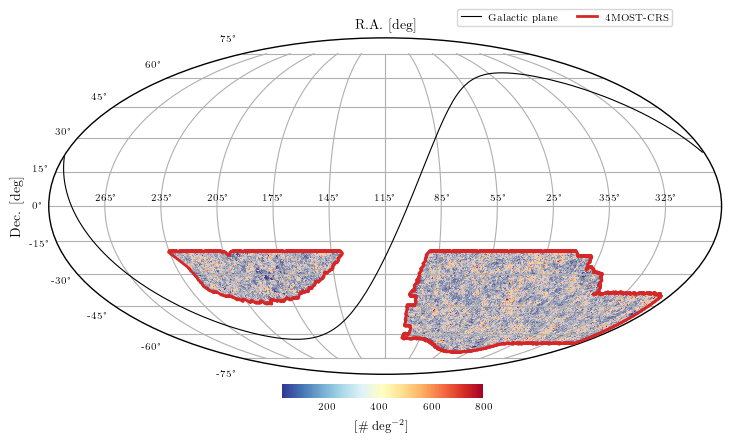

In [37]:
hpmap = utils.create_hp_map(BG['RA'], BG['DEC'], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=800, fourmost_footprint=True)

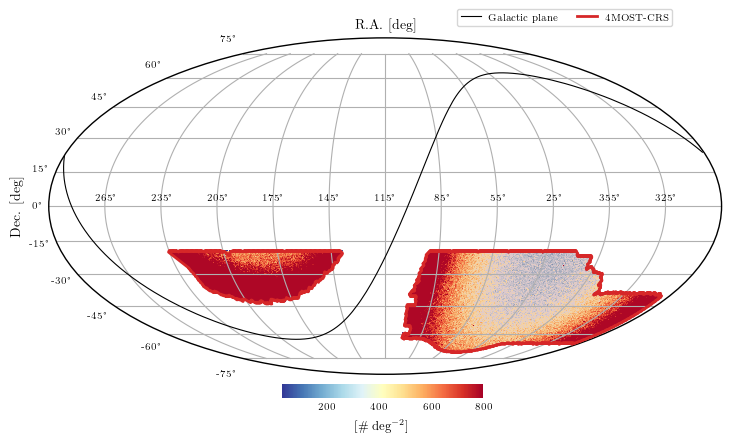

In [38]:
hpmap = utils.create_hp_map(gaia['RA'], gaia['DEC'], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=800, fourmost_footprint=True)

In [46]:
import numpy as np

def mask_radius_DR8(G):
    """
    Returns the masking radius (in arcseconds) for a Gaia star of magnitude G 
    under the DR8 prescription (larger radii).
    We use an exponential decline model R = A * 10^(-0.4 * alpha * G) 
    with parameters chosen to roughly match the expected behavior.
    """
    # Parameters A and alpha can be adjusted to fit the actual radius-magnitude relation.
    A = 826.0      # normalization (arcsec at G=0)
    alpha = 0.3    # slope parameter (controls how fast radius decreases with mag)
    return A * 10**(-0.4 * alpha * G)

def mask_radius_DR9(G):
    """
    Returns the masking radius (arcseconds) for Gaia star of magnitude G under DR9.
    In DR9, mask radii are ~half those of DR8:contentReference[oaicite:4]{index=4}.
    """
    return 0.5 * mask_radius_DR8(G)


In [43]:
bg = BG

In [40]:
mag_bins = [(8, 12), (12, 13), (13, 15), (15, 16)]


In [48]:
star_ra, star_dec = gaia['RA'].values, gaia['DEC'].values
star_mag = gaia['G'].values
star_mask_radius = mask_radius_DR9(star_mag)
bg_ra, bg_dec = bg['RA'].values, bg['DEC'].values


In [49]:
from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u

# Suppose we have star_ra, star_dec, star_mag as NumPy arrays for N_stars,
# and bg_ra, bg_dec for background objects.
star_coords = SkyCoord(ra=star_ra * u.deg, dec=star_dec * u.deg)
bg_coords   = SkyCoord(ra=bg_ra * u.deg, dec=bg_dec * u.deg)

# Define magnitude bins (edges)
mag_bins = [8, 12, 13, 14, 15, 16]  # example bin edges as specified
# Group star indices by these bins
star_bins = {}
for i in range(len(mag_bins)-1):
    lo, hi = mag_bins[i], mag_bins[i+1]
    sel = (star_mag >= lo) & (star_mag < hi)
    star_bins[(lo, hi)] = np.where(sel)[0]


In [51]:
# Dictionary to accumulate results per bin
stacked_deltas = {bin_range: [] for bin_range in star_bins}
# (We will store normalized delta positions here for stacking histograms)

for bin_range, indices in star_bins.items():
    if len(indices) == 0:
        continue  # skip empty bins
    # Compute mask radii (in degrees) for all stars in this bin using chosen prescription:
    R_mask = mask_radius_DR8(star_mag[indices])  # or mask_radius_DR9, depending on the mode
    R_mask_deg = R_mask / 3600.0  # convert arcsec to degree

    # Determine max radius for search (in degrees):
    max_radius = R_mask_deg.max() * u.deg

    # Search around all stars in this bin for background objects within max_radius
    star_subset_coords = star_coords[indices]
    idx_star, idx_bg, sep2d, _ = search_around_sky(star_subset_coords, bg_coords, seplimit=max_radius)

    # The results (idx_star, idx_bg) are index positions *within the subset* and background list.
    # Map star indices back to original:
    star_global_idx = indices[idx_star]
    # Filter out any pair where sep2d exceeds that star's actual mask (for fainter stars in bin)
    sep_deg = sep2d.to(u.deg).value  # separation in degrees as float
    mask_deg = R_mask_deg[idx_star]  # each star's mask radius in deg
    keep = sep_deg <= mask_deg
    star_global_idx = star_global_idx[keep]
    idx_bg = idx_bg[keep]
    sep_deg = sep_deg[keep]

    # Compute delta RA, delta Dec for each remaining pair
    # Note: we compute differences in an Euclidean tangent-plane approximation.
    # This is accurate for small separations; for larger separations or high declination, 
    # a projection via SkyCoord frame transformations can be used instead.
    d_ra  = (bg_ra[idx_bg] - star_ra[star_global_idx]) * np.cos(np.deg2rad(star_dec[star_global_idx]))
    d_dec =  bg_dec[idx_bg] - star_dec[star_global_idx]
    # Convert to arcseconds:
    d_ra  = d_ra * 3600.0  # deg->arcsec
    d_dec = d_dec * 3600.0
    # Normalize by the star's mask radius (also in arcsec)
    R_mask_filtered = R_mask[idx_star][keep]
    d_ra_norm  = d_ra / R_mask_filtered    # use filtered (arcsec) mask radius per star
    d_dec_norm = d_dec / R_mask_filtered
    # Store these normalized deltas for stacking
    deltas = np.column_stack((d_ra_norm, d_dec_norm))
    stacked_deltas[bin_range].append(deltas)


In [52]:
for bin_range, delta_list in stacked_deltas.items():
    if delta_list:
        stacked_deltas[bin_range] = np.vstack(delta_list)  # shape (N_pairs, 2)
    else:
        stacked_deltas[bin_range] = np.empty((0, 2))

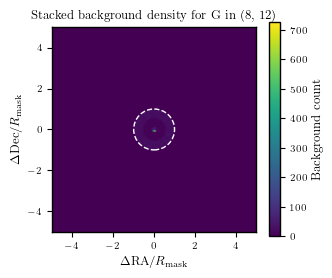

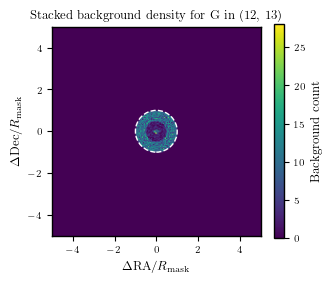

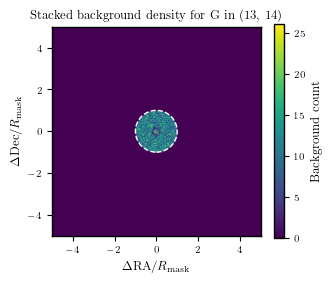

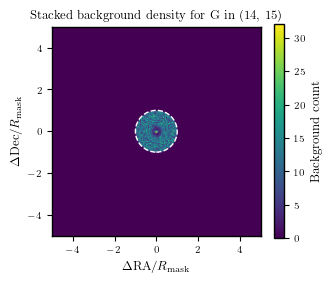

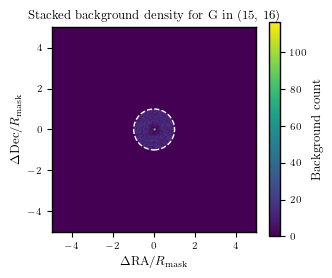

In [55]:
import matplotlib.pyplot as plt

# Define histogram grid
nbins = 200  # e.g. 50x50 grid
x_edges = y_edges = np.linspace(-5.0, 5.0, nbins+1)

for bin_range, deltas in stacked_deltas.items():
    if deltas.size == 0:
        continue
    H, _, _ = np.histogram2d(deltas[:,0], deltas[:,1], bins=[x_edges, y_edges])
    plt.figure()
    plt.imshow(H.T, origin='lower', extent=[-5,5,-5,5], cmap='viridis')
    plt.colorbar(label='Background count')
    plt.title(f'Stacked background density for G in {bin_range}')
    plt.xlabel(r'$\Delta \mathrm{RA} / R_{\mathrm{mask}}$')
    plt.ylabel(r'$\Delta \mathrm{Dec} / R_{\mathrm{mask}}$')
    # (Optionally, add a circle of radius=1 to indicate the mask boundary)
    circle = plt.Circle((0,0), 1.0, color='white', fill=False, ls='--')
    plt.gca().add_patch(circle)
    plt.tight_layout()
    plt.show()

  0%|          | 0/623 [00:00<?, ?it/s]

100%|██████████| 623/623 [00:01<00:00, 424.40it/s]


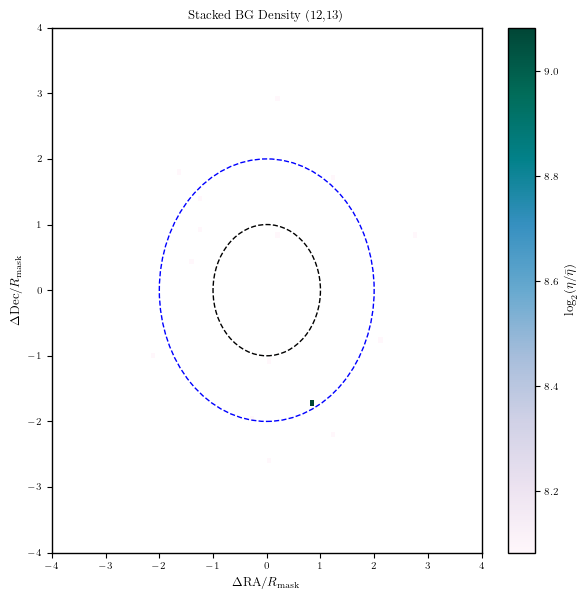

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, search_around_sky
from astropy import units as u
from matplotlib.patches import Circle
from tqdm import tqdm

# ---- Generate dummy Gaia stars ----
np.random.seed(42)
n_gaia = 5000
gaia_ra = np.random.uniform(0, 1, n_gaia) * 360  # deg
gaia_dec = np.random.uniform(-1, 1, n_gaia) * 90  # deg
gaia_gmag = np.random.uniform(8, 16, n_gaia)

# ---- Generate dummy background galaxies ----
n_bg = 500000
bg_ra = np.random.uniform(0, 1, n_bg) * 360
bg_dec = np.random.uniform(-1, 1, n_bg) * 90

# ---- Define mask radius function ----
def mask_radius(g):
    return 0.5 * 1630. * 1.396**(-g) / 3600.0  # degrees

# ---- Convert to SkyCoord ----
gaia_coords = SkyCoord(ra=gaia_ra * u.deg, dec=gaia_dec * u.deg)
bg_coords = SkyCoord(ra=bg_ra * u.deg, dec=bg_dec * u.deg)

# ---- Select stars in a magnitude bin ----
mag_bin = (12, 13)
mask = (gaia_gmag > mag_bin[0]) & (gaia_gmag <= mag_bin[1])
stars = gaia_coords[mask]
gmag_bin = gaia_gmag[mask]
r_bs_deg = mask_radius(gmag_bin)

# ---- Search around each Gaia star ----
x_all, y_all = [], []
for j in tqdm(range(len(stars))):
    r_max = r_bs_deg[j] * 3.0
    idx_star, idx_bg, sep, _ = search_around_sky(stars[j:j+1], bg_coords, seplimit=r_max * u.deg)
    if len(idx_bg) == 0:
        continue
    dx = (bg_coords[idx_bg].ra.deg - stars[j].ra.deg) * np.cos(np.deg2rad(stars[j].dec.deg))
    dy = (bg_coords[idx_bg].dec.deg - stars[j].dec.deg)
    x = dx * 3600. / (r_bs_deg[j] * 3600.)
    y = dy * 3600. / (r_bs_deg[j] * 3600.)
    x_all.append(x)
    y_all.append(y)

x_all = np.concatenate(x_all)
y_all = np.concatenate(y_all)

# ---- Create 2D histogram ----
nbins = 100
H, xe, ye = np.histogram2d(x_all, y_all, bins=nbins, range=[[-4, 4], [-4, 4]])
Xc, Yc = 0.5 * (xe[:-1] + xe[1:]), 0.5 * (ye[:-1] + ye[1:])
XX, YY = np.meshgrid(Xc, Yc)
R = np.sqrt(XX**2 + YY**2)
mask = (R > 1.1) & (R < 3.0)
eta_mean = H[mask].mean()
density_ratio = H / eta_mean

# ---- Plot ----
fig, ax = plt.subplots(figsize=(6, 6))
pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T, cmap='PuBuGn')
ax.add_patch(Circle((0, 0), 1, fill=False, ec='k', ls='--'))
ax.add_patch(Circle((0, 0), 2, fill=False, ec='b', ls='--'))
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel(r'$\Delta \mathrm{RA} / R_{\mathrm{mask}}$')
ax.set_ylabel(r'$\Delta \mathrm{Dec} / R_{\mathrm{mask}}$')


ax.set_title(f"Stacked BG Density ({mag_bin[0]},{mag_bin[1]})")
fig.colorbar(pcm, ax=ax, label=r"$\log_2(\eta/\bar{\eta})$")
plt.tight_layout()
plt.show()

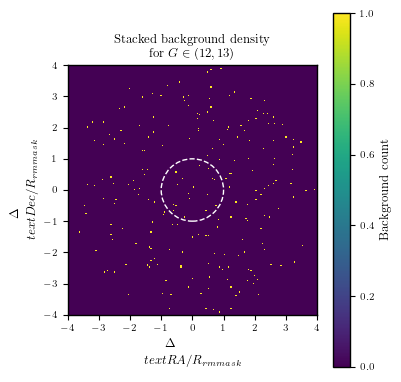

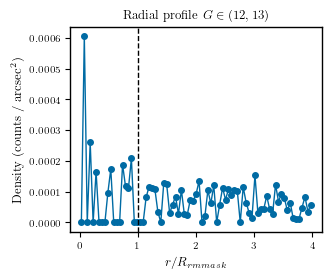

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u

# ----------------------------------------------------------------------
# -------------  INPUT  (replace with your real arrays)  ---------------
# ----------------------------------------------------------------------
# Dummy stars & background (quick test)
rng = np.random.default_rng(42)
N_stars =  3000
N_bg    = 20000
star_ra  = rng.uniform(150, 155,  N_stars)     # deg
star_dec = rng.uniform(  1,   6,  N_stars)     # deg
star_mag = rng.uniform(  8,  16, N_stars)      # Gaia G
bg_ra    = rng.uniform(150, 155,  N_bg)        # deg
bg_dec   = rng.uniform(  1,   6,  N_bg)        # deg

# ----------------------------------------------------------------------
# ------------  MASK PRESCRIPTIONS (edit to suit)  ---------------------
# ----------------------------------------------------------------------
def mask_radius_DR8(G):
    """arcsec – crude, but matches slope in DESI docs."""
    return 826.0 * 10**(-0.12 * G)             # R ~ 300″ at G=10, ~50″ at G=13

def mask_radius_DR9(G):
    return 0.5 * mask_radius_DR8(G)            # DR9 radii are ½ DR8

mask_func = mask_radius_DR9                    # << choose DR8 or DR9 here
r_extent  = 4.0                                # search to 4×R_mask

# ----------------------------------------------------------------------
# -----------------  BUILD SkyCoord OBJECTS  ---------------------------
# ----------------------------------------------------------------------
star_sc  = SkyCoord(star_ra*u.deg, star_dec*u.deg)
bg_sc    = SkyCoord(bg_ra*u.deg,   bg_dec*u.deg)

# magnitude bins
mag_bins  = [(8,12), (12,13), (13,15), (15,16)]
hist2d    = {}           # store 2-D stacks
rad_prof  = {}           # store radial profiles

# radial bins (0–r_extent in units of Rmask)
r_edges   = np.linspace(0, r_extent, 80)       # 79 annuli
r_centres = 0.5*(r_edges[:-1] + r_edges[1:])

# ----------------------------------------------------------------------
# ----------------   LOOP OVER MAGNITUDE BINS   ------------------------
# ----------------------------------------------------------------------
for lo, hi in mag_bins:
    idx_bin  = np.where((star_mag>=lo) & (star_mag<hi))[0]
    if idx_bin.size == 0:
        continue
    
    mags     = star_mag[idx_bin]
    R_arcsec = mask_func(mags)                 # per-star radii
    R_deg    = (R_arcsec/3600.0)               # convert

    # unified search radius for *this* bin:
    search_lim = (r_extent * R_deg.max()) * u.deg
    
    # cross-match
    idx_s, idx_b, sep2d, _ = search_around_sky(star_sc[idx_bin],
                                               bg_sc,
                                               seplimit=search_lim)
    if idx_s.size == 0:
        continue
    
    # Filter pairs to ≤ r_extent × each star's own Rmask
    sep_deg  = sep2d.to(u.deg).value
    keep     = sep_deg <= r_extent * R_deg[idx_s]
    idx_s, idx_b, sep_deg = idx_s[keep], idx_b[keep], sep_deg[keep]

    # ------------------------------------------------------------------
    # -------------  ΔRA, ΔDec in arcsec & normalise  ------------------
    # ------------------------------------------------------------------
    dra = (bg_ra[idx_b] - star_ra[idx_bin][idx_s]) * \
          np.cos(np.deg2rad(star_dec[idx_bin][idx_s]))
    ddec = bg_dec[idx_b] - star_dec[idx_bin][idx_s]
    dra_arc  = dra * 3600.0                     # → arcsec
    ddec_arc = ddec * 3600.0
    dra_norm  = dra_arc  / R_arcsec[idx_s]      # Δ / R_mask
    ddec_norm = ddec_arc / R_arcsec[idx_s]
    r_norm    = np.hypot(dra_norm, ddec_norm)

    # ------------------------------------------------------------------
    # ------------------ 2-D HISTOGRAM STACK ---------------------------
    # ------------------------------------------------------------------
    nbins = 200
    edges = np.linspace(-r_extent, r_extent, nbins+1)
    H, _, _ = np.histogram2d(dra_norm, ddec_norm, bins=[edges, edges])
    hist2d[(lo,hi)] = (H, edges)

    # ------------------------------------------------------------------
    # ----------------- RADIAL SURFACE DENSITY -------------------------
    # ------------------------------------------------------------------
    # counts per annulus
    counts, _ = np.histogram(r_norm, bins=r_edges)
    # total area of those annuli summed over stars  (π (r_out² - r_in²) Σ R²)
    area_ann  = np.pi * (r_edges[1:]**2 - r_edges[:-1]**2) * np.sum(R_arcsec**2)
    density   = counts / area_ann               # counts per arcsec²
    rad_prof[(lo,hi)] = (r_centres, density)

# ----------------------------------------------------------------------
# ---------------  QUICK VISUAL CHECK FOR ONE BIN  ---------------------
# ----------------------------------------------------------------------
(lo,hi) = (12,13)                               # pick a bin to show
if (lo,hi) in hist2d:
    H, edges = hist2d[(lo,hi)]
    extent   = [edges[0], edges[-1], edges[0], edges[-1]]
    plt.figure(figsize=(4,4))
    plt.imshow(H.T, origin='lower', extent=extent, cmap='viridis', vmin=0,
               interpolation='nearest')
    plt.colorbar(label='Background count')
    plt.title(f'Stacked background density\nfor $G\\in({lo}, {hi})$')
    plt.xlabel(r'$\Delta\\text{RA}/R_{\\rm mask}$')
    plt.ylabel(r'$\Delta\\text{Dec}/R_{\\rm mask}$')
    circ = plt.Circle((0,0), 1.0, fill=False, ls='--', ec='w')
    plt.gca().add_patch(circ)
    plt.tight_layout()
    plt.show()

    # radial profile
    r, dens = rad_prof[(lo,hi)]
    plt.figure()
    plt.plot(r, dens, marker='o')
    plt.axvline(1, ls='--', c='k')
    plt.xlabel(r'$r/R_{\\rm mask}$')
    plt.ylabel(r'Density  (counts / arcsec$^{2}$)')
    plt.title(f'Radial profile  $G\\in({lo},{hi})$')
    plt.tight_layout()
    plt.show()
